In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.10.1


In [9]:
# Load numpy array
data = np.load('./AP_data/age_data_images_100_100.pickle', allow_pickle=True)
df = pd.DataFrame(data)

In [10]:
def group_age(example):
    example['age'] = example['age'].apply(lambda x: "0-10" if 0 < x <= 10 
                                          else "10-20" if 10 < x <= 20 
                                          else "20-30" if 20 < x <= 30 
                                          else "30-40" if 30 < x <= 40
                                          else "40-50" if 40 < x <= 50
                                          else "50-60" if 50 < x <= 60
                                          else "60-70" if 60 < x <= 70
                                          else "70-80" if 70 < x <= 80
                                          else "80-90" if 80 < x <= 90
                                          else "90-100" if 90 < x <= 100
                                          else "100+")

In [11]:
group_age(data)

In [12]:
data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_9991,pixel_9992,pixel_9993,pixel_9994,pixel_9995,pixel_9996,pixel_9997,pixel_9998,pixel_9999,age
0,0.125490,0.149020,0.164706,0.133333,0.121569,0.098039,0.070588,0.094118,0.105882,0.125490,...,0.074510,0.078431,0.082353,0.082353,0.082353,0.082353,0.082353,0.082353,0.082353,0-10
1,0.949020,0.847059,0.650980,0.403922,0.176471,0.066667,0.145098,0.188235,0.235294,0.317647,...,0.215686,0.235294,0.266667,0.294118,0.305882,0.290196,0.278431,0.270588,0.270588,0-10
2,0.278431,0.349020,0.415686,0.482353,0.443137,0.341176,0.309804,0.305882,0.309804,0.317647,...,0.270588,0.317647,0.388235,0.407843,0.341176,0.282353,0.290196,0.333333,0.368627,0-10
3,0.254902,0.270588,0.274510,0.278431,0.270588,0.270588,0.278431,0.270588,0.258824,0.243137,...,0.392157,0.388235,0.388235,0.388235,0.396078,0.392157,0.396078,0.407843,0.415686,0-10
4,0.054902,0.062745,0.078431,0.082353,0.094118,0.078431,0.050980,0.047059,0.070588,0.078431,...,0.349020,0.352941,0.290196,0.239216,0.223529,0.243137,0.274510,0.282353,0.247059,100+


In [13]:
X = data.drop('age', axis=1).values  # Reshape for CNN input (add 1 channel)
y = data['age'].values

In [14]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def balance_dataset(X, y, method='oversample'):
    if method == 'oversample':
        sampler = RandomOverSampler()
    elif method == 'undersample':
        sampler = RandomUnderSampler()
    else:
        raise ValueError("Invalid method. Choose either 'oversample' or 'undersample'.")
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    return X_resampled, y_resampled


X, y = balance_dataset(X, y, method='oversample')



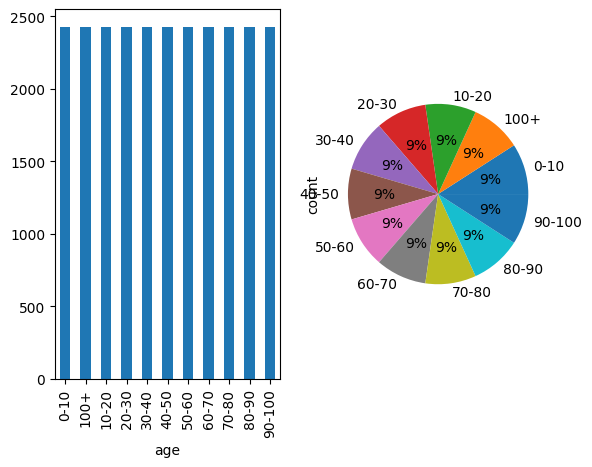

In [16]:
dist_expression = pd.DataFrame(y,columns=['age']).age.value_counts()
fig,ax = plt.subplots(nrows=1,ncols=2)
dist_expression.plot(kind='bar',ax=ax[0])
dist_expression.plot(kind='pie',ax=ax[1],autopct='%0.0f%%')
plt.show()

In [17]:
from sklearn.preprocessing import LabelEncoder

X = X.reshape(-1, 100, 100, 1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (21357, 100, 100, 1), y_train shape: (21357,)
X_test shape: (5340, 100, 100, 1), y_test shape: (5340,)


In [18]:
with open('./AP_data/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
# X = df.drop('age', axis=1).values  # PCA data with 50 components
# y = df['age'].values  # Target or dependent variable (age)

# # Reshape X to 4D tensor for CNN
# X = X.reshape(X.shape[0], 100, 100, 1)

# print(X.shape, y.shape)

In [5]:
# # Split the data into train and test
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(4744, 100, 100, 1) (1186, 100, 100, 1) (4744,) (1186,)


In [19]:
# # Build the CNN model
# def create_cnn_model(input_shape):
#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    
#     model.add(Flatten())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
    
#     model.add(Dense(1, activation='linear'))  # Regression output
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     return model

# input_shape = (100, 100, 1)
# model = create_cnn_model(input_shape)
# model.summary()


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Softmax for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [20]:
# Train the model
history = model.fit(X_train, y_train_cat, epochs=12, batch_size=32, validation_data=(X_test, y_test_cat))

Epoch 1/12
668/668 [==============================] - 564s 780ms/step - loss: 1.4523 - accuracy: 0.4618 - val_loss: 0.8137 - val_accuracy: 0.7047
Epoch 2/12
668/668 [==============================] - 217s 324ms/step - loss: 0.8018 - accuracy: 0.6870 - val_loss: 0.5729 - val_accuracy: 0.7822
Epoch 3/12
668/668 [==============================] - 194s 291ms/step - loss: 0.6105 - accuracy: 0.7506 - val_loss: 0.4256 - val_accuracy: 0.8301
Epoch 4/12
668/668 [==============================] - 196s 294ms/step - loss: 0.5152 - accuracy: 0.7887 - val_loss: 0.3740 - val_accuracy: 0.8496
Epoch 5/12
668/668 [==============================] - 195s 292ms/step - loss: 0.4464 - accuracy: 0.8109 - val_loss: 0.3395 - val_accuracy: 0.8652
Epoch 6/12
668/668 [==============================] - 195s 291ms/step - loss: 0.4063 - accuracy: 0.8271 - val_loss: 0.3013 - val_accuracy: 0.8779
Epoch 7/12
668/668 [==============================] - 199s 297ms/step - loss: 0.3604 - accuracy: 0.8491 - val_loss: 0.2839 -

In [13]:
# # Train the model
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=32, batch_size=32)

# # Save the trained model
# model.save('./AP_model/model_cnn.h5')


In [44]:
# # Model Evaluation
# y_pred = model.predict(X_test).flatten()

# # Mean Absolute Error
# mae = mean_absolute_error(y_test, y_pred)
# print(f"Mean Absolute Error (MAE): {mae}")

# # Mean Squared Error
# mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error (MSE): {mse}")

# # Root Mean Squared Error
# rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error (RMSE): {rmse}")

# # R^2 Score
# r2 = r2_score(y_test, y_pred)
# print(f"R^2 Score: {r2}")


In [46]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test_cat)
# print(f"Test Accuracy: {accuracy}")

# # Plot training history
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()


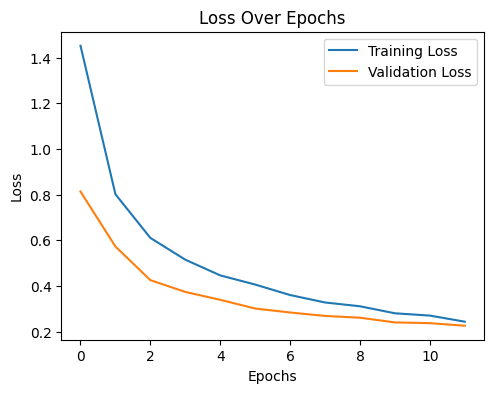

In [45]:
# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='Training MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()
# plt.title('MAE Over Epochs')

plt.show()


In [23]:
model.save('./AP_model/classification_model_cnn.h5')

In [1]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import pickle

# Load the Haar Cascade Classifier
haar_cascade = cv2.CascadeClassifier('./AP_model/haarcascade_frontalface_default.xml')


# Load the model
model = load_model('./AP_model/classification_model_cnn.h5')

# Load the label encoder
with open('./AP_data/label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

# Function to detect faces
def detect_faces(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    return faces, img, gray

# Function to preprocess the face image
def preprocess_face(face_image):
    img_resized = cv2.resize(face_image, (100, 100))
    img_normalized = img_resized / 255.0
    img_reshaped = img_normalized.reshape(1, 100, 100, 1)
    return img_reshaped

# Function to predict the age class of detected faces
def predict_age_class(image_path, model, label_encoder):
    faces, img, gray = detect_faces(image_path)
    predictions = []
    
    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        preprocessed_face = preprocess_face(face)
        prediction = model.predict(preprocessed_face)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        predicted_age_range = label_encoder.inverse_transform([predicted_class_index])[0]
        predictions.append((x, y, w, h, predicted_age_range))
    
    return predictions, img

# Function to draw bounding boxes and predicted age classes on the image
def draw_predictions(image_path, predictions):
    img = cv2.imread(image_path)
    for (x, y, w, h, age_range) in predictions:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, age_range, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    return img

# Example usage



c:\Aafrith\Age-prediction-Model\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Aafrith\Age-prediction-Model\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
c:\Aafrith\Age-prediction-Model\.venv\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [23]:
image_path = './test_images/03.jpg'
predictions, original_image = predict_age_class(image_path, model, label_encoder)
output_image = draw_predictions(image_path, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


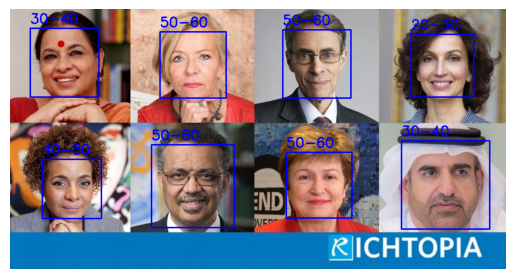

In [24]:
# Display the output image with bounding boxes and predicted age classes
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()